<h1>Learn Rate Test

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd='ian1991'
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [2]:
company_factor = get_data("""SELECT * FROM tfb103d_project.company_factor;""",'tfb103d_project')
company_factor

,data_date,stock_code,inventories,receivables,cash_equiv,cur_assets,cur_liabilities,short_debt,acc_payable,one_year_liabilities,...,tax_interest_income,cashflows_operating,invest_operating,change_rate_bys,avg_board_bys,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys
0,20183,2330,105336.58,127782.91,488732.12,5084.48,54731.05,73974.63,1571.30,34900.00,...,89098.07,384581.76,-197007.95,NaN,78.30,NaN,NaN,NaN,91.75,6.10
1,20183,2303,17588.56,25268.85,81520.16,1742.81,5349.11,14817.80,6885.73,5509.78,...,196.86,38812.36,-10886.26,NaN,24.60,NaN,NaN,NaN,75.94,21.69
2,20183,2379,6408.94,5946.09,7787.91,54362.80,3487.46,16844.80,266.01,NaN,...,1411.85,6149.88,-7548.17,NaN,11.68,NaN,NaN,NaN,67.06,21.31
3,20183,6488,6983.63,8904.46,34318.15,609.67,2120.89,6037.32,73.33,95.39,...,3633.64,30651.81,-4605.67,NaN,35.75,NaN,NaN,NaN,70.40,20.03
4,20183,5347,3276.94,5075.79,13077.13,2.94,536.79,NaN,14.92,NaN,...,1668.83,4465.47,-2407.01,NaN,52.51,NaN,NaN,NaN,88.71,7.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,20201,6756,228.25,221.52,763.59,8.13,30.70,NaN,11.31,NaN,...,74.43,62.39,-13.06,0.0,NaN,66.30,0.0,0.0,NaN,NaN
516,20202,6515,476.50,891.22,584.45,33.77,4.95,NaN,482.75,NaN,...,154.02,236.37,-54.87,0.0,NaN,21.43,0.0,0.0,NaN,NaN
517,20202,6756,229.63,256.93,820.13,11.51,25.42,NaN,12.14,NaN,...,82.20,130.72,-21.80,0.0,NaN,66.30,0.0,0.0,NaN,NaN
518,20203,6515,461.21,754.53,579.70,26.18,0.47,108.00,400.86,NaN,...,156.51,477.47,-79.82,0.0,NaN,21.40,0.0,0.0,NaN,NaN


# 以財務數據預測 毛利率

資料前處理

In [3]:
#取得需要的特徵
financial_ratio = company_factor[['stock_code',
                                  'data_date',
                                  'net_profit_rate', #稅後淨利率
                                  'operating_gross_rate', #營業毛利率
                                  'current_rate', #流動比率
                                  'quick_rate',  #速動比率
                                  'debt_rate',  #負債比率
                                  'receivables_turnover_rate', #應收帳款週轉率
                                  'inventory_turnover_rate',  #存貨週轉率
                                  'cash_reinvest_rate', #現金再投資比率
                                  'avg_director_rate', #董監事持股比利
                                  'avg_director_pledge_rate', #董監事質押比利
                                  'foreign_rate_bys', #外資持股比例
                                  'over1000_rate_bys', # >1000張大股東持股比率
                                  'under400_rate_bys', # <400張股東持股比率
                                  'avg_board_bys' #平均持股張數
                                 ]].copy() 
financial_ratio

,stock_code,data_date,net_profit_rate,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,inventory_turnover_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys
0,2330,20183,34.22,47.39,267.15,228.10,20.00,5.89,4.26,10.75,NaN,NaN,NaN,91.75,6.10,78.30
1,2303,20183,0.50,17.57,272.49,212.30,42.96,4.97,5.44,9.42,NaN,NaN,NaN,75.94,21.69,24.60
2,2379,20183,11.68,47.02,147.00,129.15,61.78,5.70,3.16,25.06,NaN,NaN,NaN,67.06,21.31,11.68
3,6488,20183,23.97,39.03,225.91,189.70,54.58,5.15,3.79,26.28,NaN,NaN,NaN,70.40,20.03,35.75
4,5347,20183,21.54,36.03,364.67,312.48,21.48,4.38,4.61,-1.59,NaN,NaN,NaN,88.71,7.41,52.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,6756,20201,17.33,49.59,322.29,260.22,29.08,1.93,0.97,6.62,66.30,0.0,0.0,NaN,NaN,NaN
516,6515,20202,17.87,38.17,169.94,126.69,45.53,1.67,2.20,15.68,21.43,0.0,0.0,NaN,NaN,NaN
517,6756,20202,16.31,50.20,218.17,178.44,42.57,3.88,2.08,15.70,66.30,0.0,0.0,NaN,NaN,NaN
518,6515,20203,18.93,40.47,226.29,166.16,35.34,2.85,3.47,6.50,21.40,0.0,0.0,NaN,NaN,NaN


In [4]:
#缺值檢視
financial_ratio.isnull().sum()

stock_code                    0
data_date                     0
net_profit_rate               6
operating_gross_rate          6
current_rate                  3
quick_rate                    3
debt_rate                     3
receivables_turnover_rate    13
inventory_turnover_rate      21
cash_reinvest_rate            3
avg_director_rate            42
avg_director_pledge_rate     42
foreign_rate_bys             42
over1000_rate_bys            10
under400_rate_bys            10
avg_board_bys                10
dtype: int64

In [5]:
#缺值處理
financial_ratio_nona = financial_ratio.copy()

#以 0 填補
financial_ratio_nona['inventory_turnover_rate'].fillna(0, inplace = True)

#刪除
financial_ratio_nona = financial_ratio_nona.dropna()

In [6]:
financial_ratio_nona.isnull().sum()

stock_code                   0
data_date                    0
net_profit_rate              0
operating_gross_rate         0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
inventory_turnover_rate      0
cash_reinvest_rate           0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
dtype: int64

In [7]:
def operating_gross(r):
    if r >= 35:
        return 1
    else:
        return 0
#定義毛利率 >35 者為表現良好

def net_profit(r):
    if r > 0:
        return 1
    else:
        return 0
#定義淨利率 >0 者為表現良好

In [8]:
# 將毛利率與淨利率轉換為 1,0 編碼，作為模型的預測目標(應變數)
financial_ratio_nona['operating_gross_rate1'] = financial_ratio_nona.apply(lambda r : operating_gross(r['operating_gross_rate']), axis = 1)
financial_ratio_nona['net_profit_rate1'] = financial_ratio_nona.apply(lambda r : net_profit(r['net_profit_rate']), axis = 1)

In [9]:
X = financial_ratio_nona[['current_rate', 'quick_rate', 'debt_rate', 'receivables_turnover_rate', 
                          'inventory_turnover_rate', 'cash_reinvest_rate','avg_director_rate',
                          'avg_director_pledge_rate','foreign_rate_bys','over1000_rate_bys',
                          'under400_rate_bys','avg_board_bys']]
y = financial_ratio_nona['operating_gross_rate1']
y1 = financial_ratio_nona['net_profit_rate1']
# print("y.shape: " ,y.shape)
# print('y.sum():',y.sum())
# print("y1.shape: " ,y1.shape)
# print('y1.sum():',y1.sum())

In [10]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 362 D: 12


<h2> 以 DNN 類神經網路實作 - 預測毛利率 (學習率測試)

In [12]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix

<h1>learning_rate = 0.01

In [14]:
# 建立TF模型
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
#編譯模型
lr = 0.01
model1.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
r1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80)

# 評估模型 - evaluate() returns loss and accuracy
print("=====================================================================")
print("Train score:", model1.evaluate(X_train, y_train))

print("Test score:", model1.evaluate(X_test, y_test))

Epoch 1/80
12/12 [==============================] - 0s 13ms/step - loss: 0.5308 - accuracy: 0.7431 - val_loss: 0.4457 - val_accuracy: 0.7912
Epoch 2/80
12/12 [==============================] - 0s 2ms/step - loss: 0.4603 - accuracy: 0.8011 - val_loss: 0.4570 - val_accuracy: 0.8022
Epoch 3/80
12/12 [==============================] - 0s 2ms/step - loss: 0.3991 - accuracy: 0.8315 - val_loss: 0.3696 - val_accuracy: 0.8462
Epoch 4/80
12/12 [==============================] - 0s 2ms/step - loss: 0.3380 - accuracy: 0.8536 - val_loss: 0.3498 - val_accuracy: 0.8132
Epoch 5/80
12/12 [==============================] - 0s 2ms/step - loss: 0.2809 - accuracy: 0.8785 - val_loss: 0.2893 - val_accuracy: 0.8681
Epoch 6/80
12/12 [==============================] - 0s 2ms/step - loss: 0.2944 - accuracy: 0.8702 - val_loss: 0.3160 - val_accuracy: 0.8681
Epoch 7/80
12/12 [==============================] - 0s 2ms/step - loss: 0.2567 - accuracy: 0.8867 - val_loss: 0.3165 - val_accuracy: 0.8462
Epoch 8/80
12/12 [=

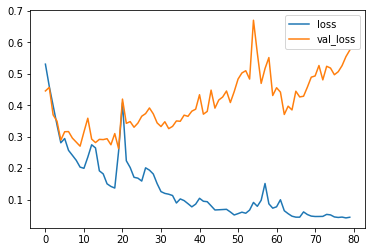

In [16]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r1.history['loss'], label='loss')
plt.plot(r1.history['val_loss'], label='val_loss')
plt.legend()

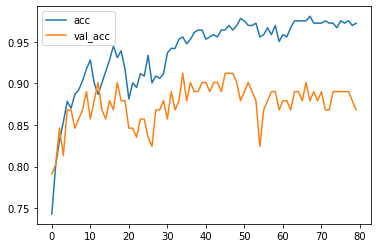

In [17]:
# 劃出準確性 accuracy 
plt.plot(r1.history['accuracy'], label='acc')
plt.plot(r1.history['val_accuracy'], label='val_acc')
plt.legend()

In [20]:
pred_test = model1.predict(X_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[41,  8],
       [ 4, 38]], dtype=int64)

<h1>learning_rate = 0.001

In [22]:
# 建立TF模型
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
#編譯模型
lr = 0.001
model2.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
r2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=120)

# 評估模型 - evaluate() returns loss and accuracy
print("=====================================================================")
print("Train score:", model2.evaluate(X_train, y_train))

print("Test score:", model2.evaluate(X_test, y_test))

Epoch 1/120
12/12 [==============================] - 0s 10ms/step - loss: 0.6382 - accuracy: 0.6768 - val_loss: 0.5484 - val_accuracy: 0.7253
Epoch 2/120
12/12 [==============================] - 0s 2ms/step - loss: 0.5396 - accuracy: 0.7376 - val_loss: 0.4869 - val_accuracy: 0.7802
Epoch 3/120
12/12 [==============================] - 0s 2ms/step - loss: 0.4915 - accuracy: 0.7818 - val_loss: 0.4580 - val_accuracy: 0.7912
Epoch 4/120
12/12 [==============================] - 0s 2ms/step - loss: 0.4581 - accuracy: 0.8011 - val_loss: 0.4310 - val_accuracy: 0.8022
Epoch 5/120
12/12 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8370 - val_loss: 0.4099 - val_accuracy: 0.8242
Epoch 6/120
12/12 [==============================] - 0s 2ms/step - loss: 0.4088 - accuracy: 0.8481 - val_loss: 0.3955 - val_accuracy: 0.8132
Epoch 7/120
12/12 [==============================] - 0s 3ms/step - loss: 0.3916 - accuracy: 0.8453 - val_loss: 0.3764 - val_accuracy: 0.8352
Epoch 8/120


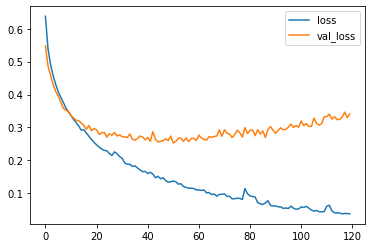

In [24]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r2.history['loss'], label='loss')
plt.plot(r2.history['val_loss'], label='val_loss')
plt.legend()

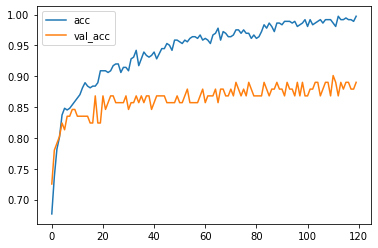

In [25]:
# 劃出準確性 accuracy 
plt.plot(r2.history['accuracy'], label='acc')
plt.plot(r2.history['val_accuracy'], label='val_acc')
plt.legend()

In [26]:
pred_test2 = model2.predict(X_test)
pred_test2 = np.round(pred_test2).flatten()
cm2 = confusion_matrix(y_test, pred_test2)
cm2

array([[43,  6],
       [ 4, 38]], dtype=int64)

<h1>learning_rate = 0.0001

In [27]:
# 建立TF模型
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               6656      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 10,769
Trainable params: 10,769
Non-trainable params: 0
_________________________________________________________________


In [29]:
#編譯模型
lr = 0.0001
model.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
# 訓練模型
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150)

# 評估模型 - evaluate() returns loss and accuracy
print("=====================================================================")
print("Train score:", model.evaluate(X_train, y_train))

print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/150
12/12 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.5304 - val_loss: 0.6806 - val_accuracy: 0.6044
Epoch 2/150
12/12 [==============================] - 0s 2ms/step - loss: 0.6726 - accuracy: 0.6796 - val_loss: 0.6595 - val_accuracy: 0.7033
Epoch 3/150
12/12 [==============================] - 0s 2ms/step - loss: 0.6561 - accuracy: 0.7238 - val_loss: 0.6421 - val_accuracy: 0.7253
Epoch 4/150
12/12 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.7127 - val_loss: 0.6273 - val_accuracy: 0.7143
Epoch 5/150
12/12 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.7210 - val_loss: 0.6132 - val_accuracy: 0.7253
Epoch 6/150
12/12 [==============================] - 0s 2ms/step - loss: 0.6146 - accuracy: 0.7348 - val_loss: 0.6017 - val_accuracy: 0.7253
Epoch 7/150
12/12 [==============================] - 0s 3ms/step - loss: 0.6036 - accuracy: 0.7376 - val_loss: 0.5902 - val_accuracy: 0.7253
Epoch 8/150


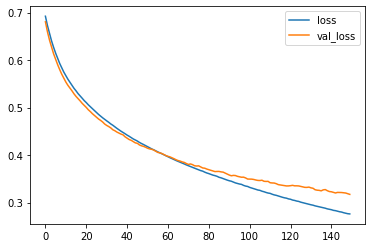

In [31]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

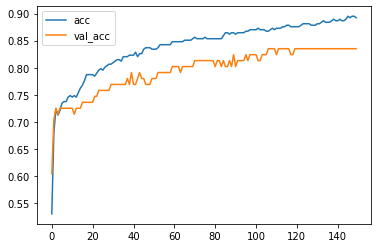

In [32]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [33]:
pred_test0 = model.predict(X_test)
pred_test0 = np.round(pred_test0).flatten()
cm0 = confusion_matrix(y_test, pred_test0)
cm0

array([[39, 10],
       [ 5, 37]], dtype=int64)

<h1>learning_rate = 0.00001

In [34]:
# 建立TF模型
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [35]:
#編譯模型
lr = 0.00001
model3.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
r3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300)

# 評估模型 - evaluate() returns loss and accuracy
print("=====================================================================")
print("Train score:", model3.evaluate(X_train, y_train))

print("Test score:", model3.evaluate(X_test, y_test))

Epoch 1/300
12/12 [==============================] - 0s 10ms/step - loss: 0.6812 - accuracy: 0.6160 - val_loss: 0.6832 - val_accuracy: 0.6044
Epoch 2/300
12/12 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.6188 - val_loss: 0.6813 - val_accuracy: 0.6154
Epoch 3/300
12/12 [==============================] - 0s 2ms/step - loss: 0.6777 - accuracy: 0.6271 - val_loss: 0.6794 - val_accuracy: 0.6154
Epoch 4/300
12/12 [==============================] - 0s 2ms/step - loss: 0.6761 - accuracy: 0.6243 - val_loss: 0.6776 - val_accuracy: 0.5934
Epoch 5/300
12/12 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.6326 - val_loss: 0.6757 - val_accuracy: 0.5934
Epoch 6/300
12/12 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.6326 - val_loss: 0.6740 - val_accuracy: 0.6044
Epoch 7/300
12/12 [==============================] - 0s 2ms/step - loss: 0.6712 - accuracy: 0.6381 - val_loss: 0.6722 - val_accuracy: 0.6044
Epoch 8/300


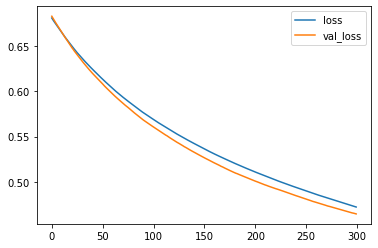

In [36]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r3.history['loss'], label='loss')
plt.plot(r3.history['val_loss'], label='val_loss')
plt.legend()

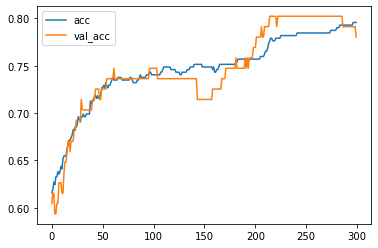

In [37]:
# 劃出準確性 accuracy 
plt.plot(r3.history['accuracy'], label='acc')
plt.plot(r3.history['val_accuracy'], label='val_acc')
plt.legend()

In [38]:
pred_test3 = model3.predict(X_test)
pred_test3 = np.round(pred_test3).flatten()
cm3 = confusion_matrix(y_test, pred_test3)
cm3

array([[39, 10],
       [10, 32]], dtype=int64)